# Gaussian processes
## Back to basics

Collection of datasets taken from https://www.sfu.ca/~ssurjano/optimization.html

In [1]:
import jax
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
jax.config.update("jax_enable_x64", True)

%config InlineBackend.figure_format = "retina"

Let $Y: {\cal X} \to \mathbb{R}$ be a random variable
such that, for any $x_i, x_j \in {\cal X}$,
$$
\begin{aligned}
    \mathbb{E}[Y(x_i)] &= 0\\
    {\rm Cov}(Y(x_i),Y(x_j)) = \mathbb{E}[Y(x_i)\,Y(x_j)] &= k(x_i\,x_j)
\end{aligned}
$$

where $k:\mathbb{R}^m\times\mathbb{R}^m\to\mathbb{R}$ is a valid *kernel function*.
In a Gaussian process, we assume we are always given members of the sample space 
and $\{x_1, \ldots, x_t\} \subseteq {\cal X} \subseteq {\mathbb R}^m$,
but we are not given

We seek the best linear unbiased predictor for $j$-th future random variables.
$$
    {\bf A}^* = \arg\min_{{\bf A}}\|Y_{t+1:t+j} - {\bf A}\,Y_{1:t}\|^2_2
$$

This takes the form

$$
    {\bf A}^* = {\rm Cov}(Y_{t+1,t+j},Y_{1:T})\,{\rm Var}(Y_{1:t})^{-1}
$$

As a consequence, the best linear unbiased predictor and the error variance-covariance matrix take the form
$$
\begin{aligned}
    \hat{Y}_{1:t} = {\bf A}^*\,Y_{1:t}
    &= {\rm Cov}(Y_{t+1,t+j},Y_{1:T})\,{\rm Var}(Y_{1:t})^{-1}\,Y_{1:T}\\
    {\rm Var}(Y_{1:t} - \hat{Y}_{1:t}) &= {\rm Var}(Y_{t+1:t+j}) - {\bf A}^*\,{\rm Var}(Y_{1:t})\,{\bf A}^{*\intercal}
\end{aligned}
$$

Because we assume knowledge of the covariance between any two elements of the sample space ${\cal X}$,
it follows that the G prediction is completely determined by its kernel function.

In [3]:
def kgauss(u, v, sigma2=1.0):
    return jnp.exp(-(u[:, None] - v[None, :]) ** 2 / (2 * sigma2))

In [4]:
key = jax.random.PRNGKey(314)
key_x, key_sample = jax.random.split(key)

n = 100
x = jax.random.uniform(key=key_x, minval=-1, maxval=1, shape=(n,)).sort()[:, None]
x = jnp.linspace(-1, 1, n)

sigma2 = 0.1
reg = 1e-7
mean = jnp.zeros(n)
cov = kgauss(x, x, sigma2) + jnp.eye(n) * reg

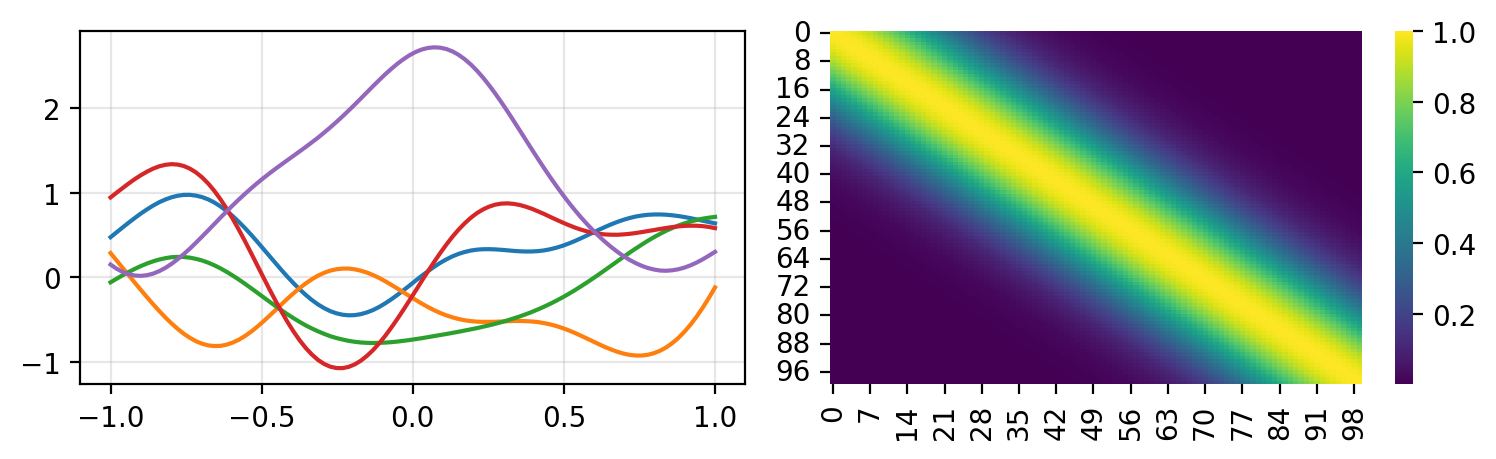

In [5]:
fig, ax = plt.subplots(1,2, figsize=(6.4 * 1.2, 4.8 * 0.5))

sample = jax.random.multivariate_normal(key_sample, mean, cov, shape=(5,))
ax[0].plot(x, sample.T)
ax[0].grid(alpha=0.3)

sns.heatmap(cov, cmap="viridis", ax=ax[1])
plt.tight_layout()

## Posterior

In [36]:
def sample_multivariate_gauss(key, mean, cov, n_samples, min=1e-7):
    dim = cov.shape[0]
    cov = (cov + cov.T) / 2
    ev = jnp.linalg.eigh(cov)
    cov = ev.eigenvectors @ jnp.diag(jnp.clip(ev.eigenvalues, min=1e-7)) @ jnp.linalg.inv(ev.eigenvectors)
    L = jnp.linalg.cholesky(cov)
    rvs = jax.random.normal(key, shape=(dim, n_samples))
    return (L @ rvs) + mean[:, None]

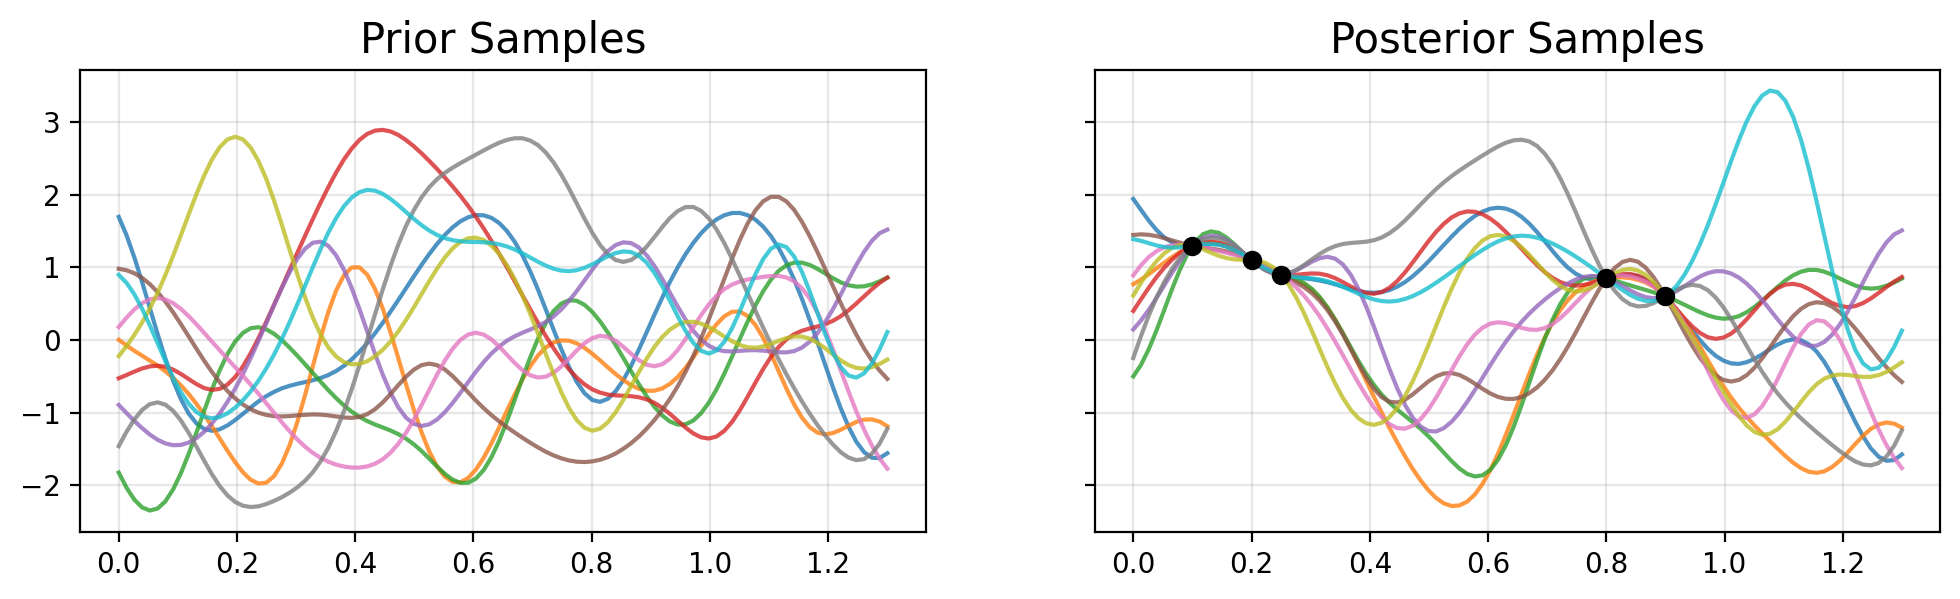

In [37]:
# from numpy.linalg import inv
xtest = jnp.linspace(0, 1.3, 100)
mean_prior = jnp.zeros_like(xtest)
sigma = 0.01
n_samples = 10
x = jnp.array([0.1, 0.2, 0.25, 0.8, 0.9])
y = jnp.array([1.3, 1.1, 0.9, 0.85, 0.6])
beta_inv = 0.00

K_train = kgauss(x, x, sigma)
K_pred = kgauss(xtest, x, sigma)
K_eval = kgauss(xtest, xtest, sigma)

A_blup = jnp.linalg.solve(K_train, K_pred.T).T
mu_post = A_blup @ y
sigma_post = K_eval - A_blup @ K_train @ A_blup.T

posterior_sample = sample_multivariate_gauss(key, mu_post, sigma_post, n_samples=n_samples)
prior_sample = sample_multivariate_gauss(key, mean_prior, K_eval, n_samples=n_samples)

fig, ax = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

ax[0].plot(xtest, prior_sample, alpha=0.8);
ax[1].plot(xtest, posterior_sample, alpha=0.8);
ax[1].scatter(x, y, marker="o", c="black", zorder=5)
ax[0].set_title("Prior Samples", fontsize=15)
ax[1].set_title("Posterior Samples", fontsize=15)
for axi in ax:
    axi.grid(alpha=0.3)

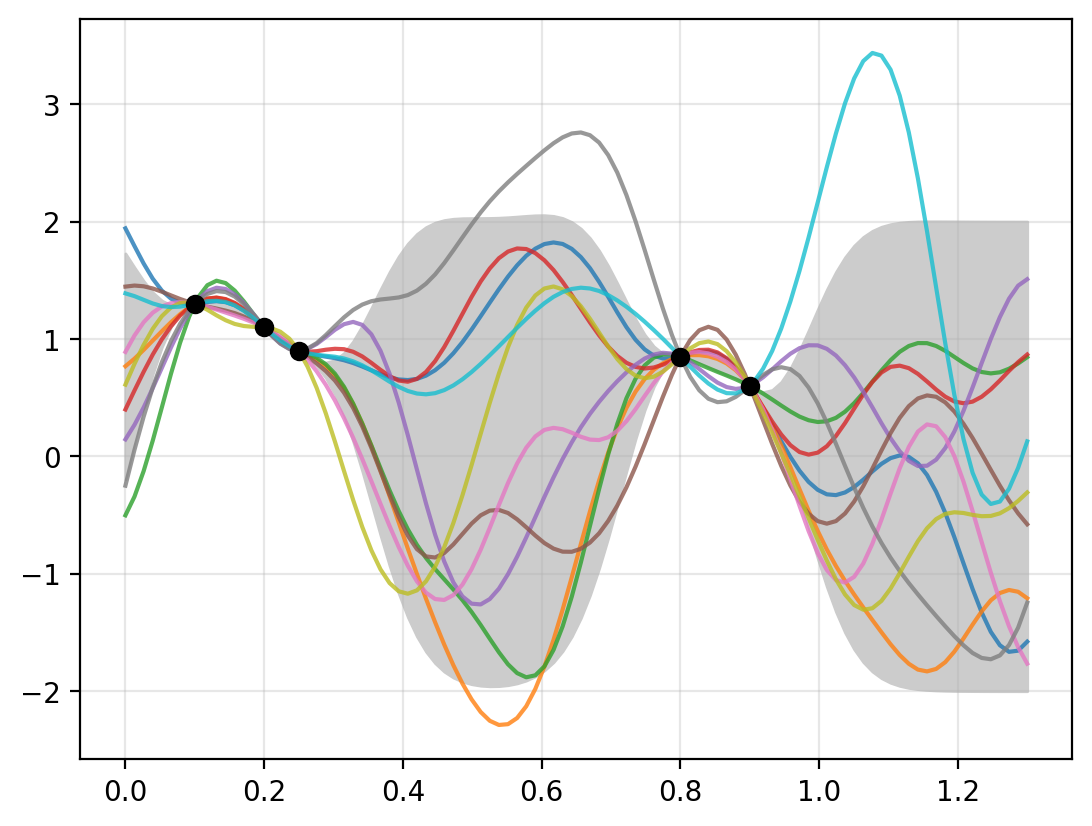

In [38]:
upper_bound = mu_post.ravel() + 2 * jnp.diag(sigma_post)
lower_bound = mu_post.ravel() - 2 * jnp.diag(sigma_post)

plt.plot(xtest, posterior_sample, alpha=0.8);
plt.scatter(x, y, marker="o", c="black", zorder=5)
plt.fill_between(xtest, lower_bound, upper_bound, color="#ccc")
plt.grid(alpha=0.3)